In [1]:
!wget https://goo.gl/8hY5ER
!tar xf 8hY5ER

--2020-10-23 03:38:44--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 172.217.13.238, 2607:f8b0:4004:809::200e
Connecting to goo.gl (goo.gl)|172.217.13.238|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2020-10-23 03:38:45--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘8hY5ER’

8hY5ER              100%[===================>]   5.61G  18.5MB/s    in 6m 20s  

2020-10-23 03:45:05 (15.1 MB/s) - ‘8hY5ER’ saved [6023741708/6023741708]



In [2]:
!ls UrbanSound8K/audio/

fold1  fold10  fold2  fold3  fold4  fold5  fold6  fold7  fold8	fold9


In [3]:
import IPython
IPython.display.Audio("UrbanSound8K/audio/fold10/101382-2-0-21.wav")

In [9]:
labels  = ['air_conditioner','car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']

In [5]:
!mkdir 'UrbanSound8K/spectrogram'

In [2]:
import os
import glob
import librosa
import shutil
import librosa.display
import numpy as np
from pathlib import Path  
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

def create_fold_spectrograms(fold):
    spectrogram_path = Path('UrbanSound8K/spectrogram/')  
    audio_path = Path('UrbanSound8K/audio/')  
    print(f'Processing fold {fold}')
    os.mkdir(spectrogram_path/fold)
    for audio_file in list(Path(audio_path/f'fold{fold}').glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [5]:
#for i in range(1,11):
create_fold_spectrograms(str(10))

Processing fold 10


In [29]:
!mkdir 'UrbanSound8K/data'
!mkdir 'UrbanSound8K/data/train'
!mkdir 'UrbanSound8K/data/valid'

In [30]:
train_path = Path('UrbanSound8K/data/train') 
valid_path = Path('UrbanSound8K/data/valid')
spectrogram_path = Path('UrbanSound8K/spectrogram/') 
for label in labels:
    os.mkdir(train_path/label)
    os.mkdir(valid_path/label) 
def create_fold_directory(fold):
    
    #os.mkdir(data_path/fold)
    #os.mkdir(data_path/'train')
    #os.mkdir(data_path/'valid')
    
    png_files =  list(Path(spectrogram_path/fold).glob('*.png')) 
    for file in png_files:
        label = file.as_posix().split('-')[1]
        shutil.copyfile(file, valid_path/labels[int(label)]/file.name)   
    for i in range(1, 11):       
        if str(i) == fold:
            continue
        png_files =  list(Path(spectrogram_path/str(i)).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, train_path/labels[int(label)]/file.name) 

In [60]:
shutil.rmtree('/content/UrbanSound8K/data/valid', ignore_errors=True)

In [31]:
for i in range(1, 11):
    create_fold_directory(str(i))

In [48]:
total=0
for label in labels:
  files = [x for x in os.listdir(train_path/label)]
  print(label,len(files))
  total+=len(files)
print(total)

air_conditioner 978
car_horn 418
children_playing 979
dog_bark 974
drilling 970
engine_idling 977
gun_shot 363
jackhammer 984
siren 918
street_music 975
8536


In [55]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.vision.data import *

In [73]:
data_directory = Path('UrbanSound8K/data/train')
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
data = ImageDataBunch.from_folder(path=data_directory,
                              valid_pct=0.2,ds_tfms=[], size=224).normalize(imagenet_stats)

In [74]:
data

ImageDataBunch;

Train: LabelList (6829 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
air_conditioner,air_conditioner,air_conditioner,air_conditioner,air_conditioner
Path: UrbanSound8K/data/train;

Valid: LabelList (1707 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
air_conditioner,children_playing,dog_bark,siren,engine_idling
Path: UrbanSound8K/data/train;

Test: None

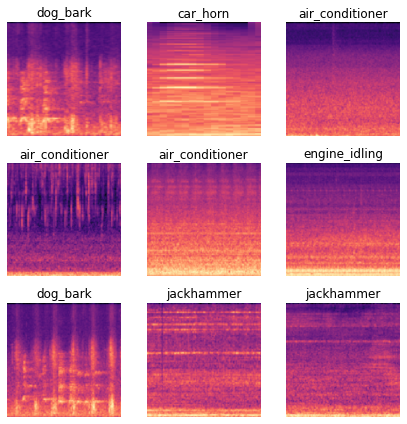

In [75]:
data.show_batch(rows=3, figsize=(6,6))

In [76]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy])

In [77]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


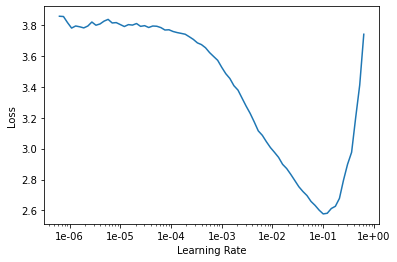

In [78]:
learn.recorder.plot()

In [79]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.561997,0.716667,0.780316,00:49
1,0.912124,0.548400,0.817809,00:48
2,0.588811,0.467095,0.842999,00:48
3,0.396653,0.377997,0.876391,00:48
4,0.318479,0.370059,0.884593,00:48


In [80]:
learn.fit_one_cycle(5,max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.455864,0.671850,0.797305,00:48
1,0.686044,0.490256,0.861160,00:48
2,0.399108,0.272535,0.920914,00:48
3,0.216160,0.235851,0.927358,00:48
4,0.129107,0.209117,0.934974,00:48


In [81]:
learn.save('stage-1')

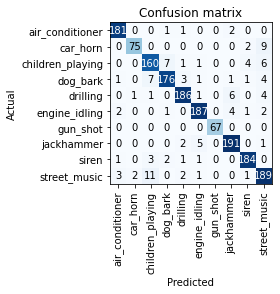

In [82]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

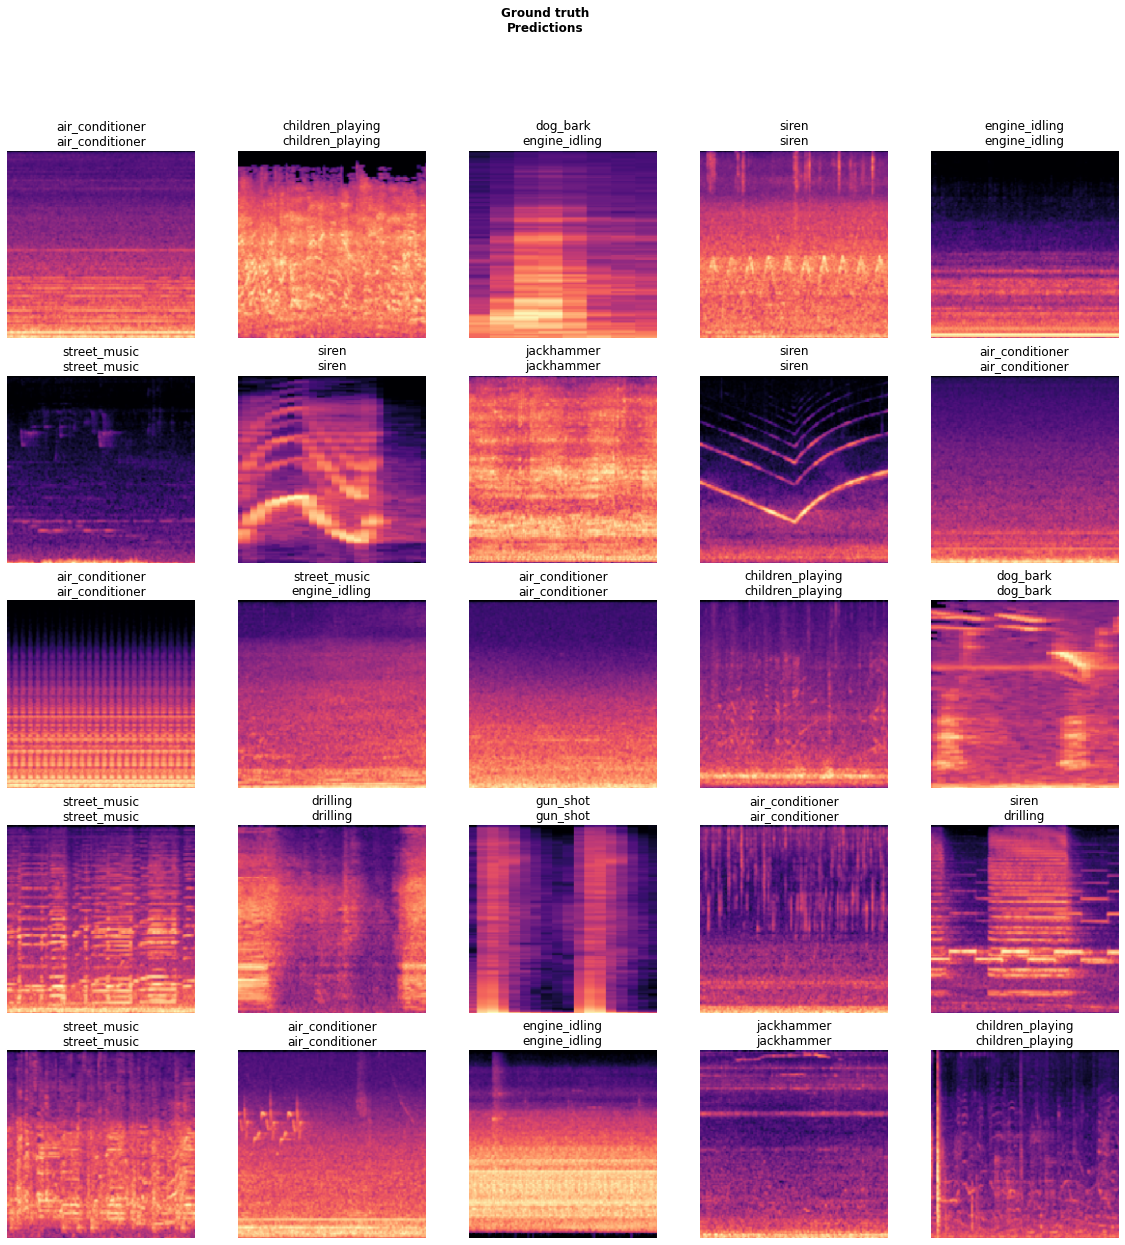

In [83]:
learn.show_results()

In [84]:
learn.unfreeze()
learn.fit_one_cycle(5,max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.674270,1.522662,0.683070,00:50
1,0.732157,0.684810,0.778559,00:50
2,0.392885,0.328809,0.885764,00:50
3,0.211254,0.148517,0.947862,00:50
4,0.095551,0.118451,0.957821,00:50


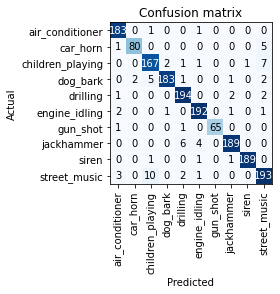

In [85]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [86]:
learn.save('stage-2')

In [102]:
from fastai.vision import image
img=image.open_image('/content/UrbanSound8K/data/train/gun_shot/122690-6-0-0.png')
y=learn.predict(img)[1]
labels[y]

'gun_shot'

In [ ]:
import IPython
IPython.display.Audio("UrbanSound8K/audio/fold10/101382-2-0-21.wav")

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
learn.export(Path('/content','model.pkl'))